# [데이콘 온라인 스터디] 1주차 - 탐색적 데이터 분석(EDA)

## 불균형한 데이터 분포, 어떻게 처리해야 할까?

지난 6월부터 7월 중순까지 약 4주간에 걸쳐 원자력 상태판단대회 온라인 스터디(2기)가 진행되었습니다. 스터디에서 진행한 내용을 보다 많은 분들과 고민하고자 앞으로 3차례에 걸쳐 코드공유 게시물을 업로드할 예정입니다.

온라인 스터디와 관련한 자료는 아래 링크를 참조해 주세요.

- 데이콘 온라인 스터디 커리큘럼 [바로가기](https://www.dropbox.com/scl/fi/eaxxhf0pudm9jvckqgf4k/.papert?dl=0&rlkey=yqyrpk9eluqauoi5xjmywmp66)
- 1주차 세션 진행 자료 [바로가기](https://www.dropbox.com/scl/fi/hj22v4f47ythje8flvvm2/1.paper?dl=0&rlkey=0mrorfzb3hnvauscl459gl50z)

첫번째 주제는 <불균형한 데이터 분포, 어떻게 처리해야 할까?>로, 데이터의 분포도를 살펴보고 데이터 분포의 불균형이 초래할 수 있는 문제와 리샘플링 방법에 대해 다뤄보고자 합니다.

-------------

### 1. 데이터 로드

데이터 로드 시 데이콘에서 제공한 베이스라인 코드를 참조하였습니다.

다만, 상태 A에서 B로 변화하는 ~15초 구간, 즉 event_time변수 값을 기존 10에서 15로 변경하여 모든 측정치가 상태 B인 구간만을 사용하였습니다.

우승자 코드를 살펴보면 일부 팀에서 1초부터 15초 까지 1초간 변화를 주어 약 15개의 데이터셋을 활용하여 모델을 구성하기도 했는데, 각 측정치마다 변화 시점이 같다고 판단하기 어려우므로 상태 B에 대해 집중하기로 결정하였습니다.

상태 A와 B에 대해 상관관계를 도출하고자 여러 시도를 했는데, 유의미한 인사이트를 아직 얻지 못했습니다. 이 부분에 대해서는 조금 더 고민을 해봐야 할 것 같습니다.

추가로, nrows는 75로 설정하여 60초의 데이터를 가져올 수 있도록 하였습니다.

In [3]:
import multiprocessing 
from multiprocessing import Pool 
from functools import partial 
from data_loader_v2 import data_loader_v2
import os 
import pandas as pd
import numpy as np
import joblib

In [4]:
train_folder = 'train/'
train_list = os.listdir(train_folder)
train_label_path = 'train_label.csv'
train_label = pd.read_csv(train_label_path, index_col=0)

In [5]:
def data_loader_all_v2(func, files, folder='', train_label=None, event_time=15, nrows=75):   
    func_fixed = partial(func, folder=folder, train_label=train_label, event_time=event_time, nrows=nrows)  
    if __name__ == '__main__':
        pool = Pool(processes=multiprocessing.cpu_count()) 
        df_list = list(pool.imap(func_fixed, files)) 
        pool.close() 
        pool.join() 
    combined_df = pd.concat(df_list)
    return combined_df

In [6]:
# event_time=15, nrows=75 설정
train = data_loader_all_v2(data_loader_v2, train_list, folder=train_folder, train_label=train_label, event_time=15, nrows=75)

---------

### 2. 데이터 처리

본 대회의 데이터는 칼럼이 많은 것이 특징입니다. 약 5000여개의 칼럼에서 row에 따라 값이 변하지 않는 칼럼은 의미없는 칼럼으로 간주하여 해당 칼럼을 삭제하는 작업을 진행하였습니다.  물론, train 데이터에서 drop된 칼럼은 test에서도 동일하게 drop되었습니다.

결과적으로 5122개의 칼럼에서 3339여개의 칼럼으로 축소할 수 있었습니다. 해당 시도가 과연 유의미했는지 여부는 다음 게시물에서 추가로 설명하겠습니다.

In [7]:
train_1 = train.loc[:,train.nunique()!=1]

In [8]:
train.shape

(49620, 5122)

In [9]:
train_1.shape

(49620, 3339)

In [11]:
X_train = train_1.drop(['label'], axis=1)
y_train = train_1['label']

-----

### 3. 데이터 분포

라벨 별 데이터의 분포를 통해 데이터 분포를 살펴보겠습니다.

110라벨의 경우 약 20여개의 데이터가 포함된 반면 일부 라벨은 1개의 데이터만 포함된 경우도 더러 있습니다. 데이터의 불균형한 분포가 부적절하다고 판단하여 이를 리샘플링해서 균형을 맞추고자 진행하였습니다.

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings

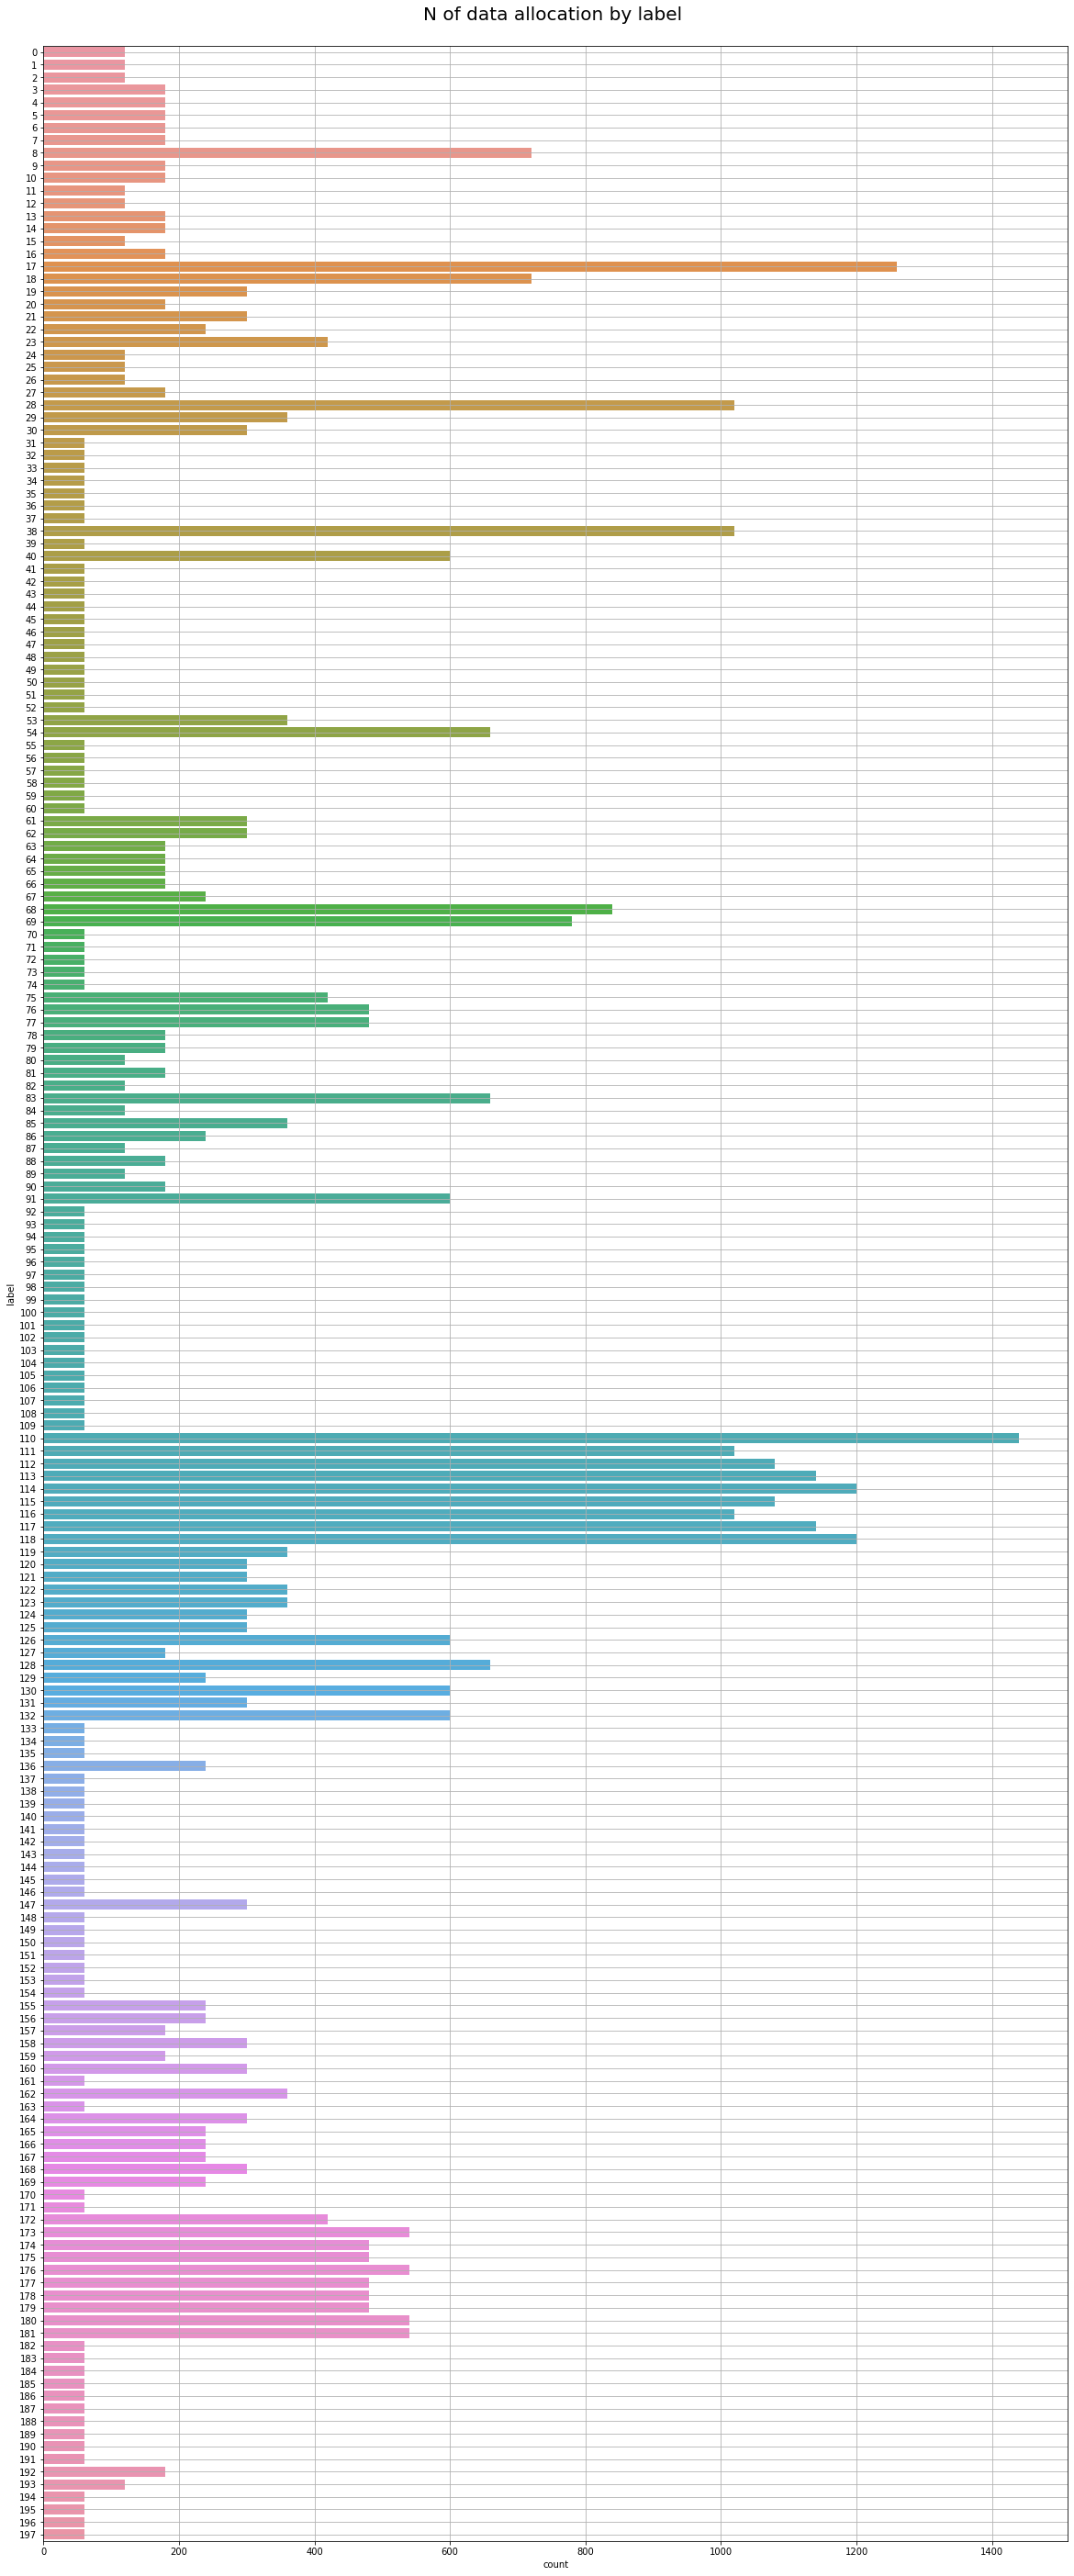

In [17]:
#라벨 별 분포도
warnings.filterwarnings(action='ignore')
plt.figure(figsize=(20, 50))
sns.countplot(y=y_train)
plt.title('N of data allocation by label \n', size=20)
plt.grid()

plt.show()

불균형한 데이터 문제를 해결하기 위해서는 분류 알고리즘 자체의 성능을 향상시키거나, 리샘플링하여 균형을 맞추는 방법이 고려됩니다. 리샘플링을 위해서는 데이터셋 내에서 상대적으로 다수를 차지하는 클래스의 비중을 낮추기 위해 1) 적은 클래스의 비중을 높이거나(Over-Sampling), 2) 다수를 차지하는 클래스를 줄이는 방법(Under-Sampling)등이 있습니다.

리샘플링 방법과 결과에 대해서는 다음 게시물에서 살펴보도록 하겠습니다.

-----